In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [2]:
# Command to use the full widht of the screen
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }/style>"))

# Small test to run:
git push origin master

In [3]:
def BACN(init_nodes, final_nodes, m_param, l_param=0, CN=False, DIR=False):###, new_edges_only_on_new_nodes=False):
    assert init_nodes > 1
    assert init_nodes < final_nodes
    assert init_nodes >= m_param
    assert l_param >= 0
    start = time.time()
    A = np.zeros((final_nodes, final_nodes)) 
    for i in range(init_nodes):
        for j in range(i+1, init_nodes):
            A[i,j] = 1
            A[j,i] = 1
    for i in range(init_nodes, final_nodes):
        if DIR:
            p_deg_target = np.sum(A[:i,:], axis=1)
            p_deg_target /= np.sum(p_deg_target)
            p_deg_source = np.sum(A[:,:i], axis=0)
            p_deg_source /= np.sum(p_deg_source)
            rand_target = np.random.choice(i, size=m_param, p=p_deg_target, replace=False)
            A[rand_target, i] = 1
            rand_source = np.random.choice(i, size=m_param, p=p_deg_source, replace=False)
            A[i, rand_source] = 1
        else:
            p_deg = np.sum(A, axis=1)[:i]
            p_deg /= np.sum(p_deg)
            rand_node = np.random.choice(i, size=m_param, p=p_deg, replace=False)
            A[i, rand_node] = A[rand_node, i] = 1
        #print("\nA")
        #print(A)
        if CN and l_param > 0:
            S = A[:i+1,:i+1]
            #print("First S")
            #print(S)
            cn_mat = S @ S
            #print("cn_mat")
            #print(cn_mat)
            S[np.eye(S.shape[0], dtype=bool)] = -1
            #print("Second S")
            #print(S)
            missing = np.nonzero(S==0)
            #print("missing:", missing)
            if DIR==False:
                missing = (missing[0][missing[0]<missing[1]], missing[1][missing[0]<missing[1]]) #only upper triangle of adjacency matrix
                #print("missing", missing)
            ###if new_edges_only_on_new_nodes:
            ###    missing = (missing[0][missing[0]>=i], missing[1][missing[0]>=i])
            ###    print("missing", missing)
            if missing[0].size != 0:
                p_cn = cn_mat[missing]
                p_cn /= np.sum(p_cn)
                #print("p_cn", p_cn)
                #print(np.unique(p_cn))
                if np.isnan(p_cn).all():
                    if l_param < missing[0].size:
                        #print("if")
                        rand_edge = np.random.choice(missing[0].size, size=l_param, replace=False)
                    else:
                        #print("else")
                        rand_edge = range(missing[0].size)
                else:
                    if l_param > np.count_nonzero(p_cn):
                        #print("IF")
                        rand_edge = np.random.choice(missing[0].size, size=np.count_nonzero(p_cn), p=p_cn, replace=False)
                    else:
                        #print("ELSE")
                        rand_edge = np.random.choice(missing[0].size, size=l_param, p=p_cn, replace=False)
                #print("rand_edge", rand_edge)
                a = missing[0][rand_edge]
                #print("a", a)
                b = missing[1][rand_edge]
                #print("b", b)
                if DIR:
                    A[a,b] =  1
                else:
                    A[a,b] = A[b,a] = 1
                #print("A")
                #print(A)
            S[np.eye(S.shape[0], dtype=bool)] = 0
            #print("Fourth S")
            #print(S)
    end = time.time()
    #print('Elapsed time:', end - start, 'seconds')
    return A

In [4]:
testBACN = BACN(3,10,3,6,CN=True)#,DIR=True)
testBACN

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [5]:
np.array_equal(testBACN, testBACN.T)

True

In [6]:
def cns_number(x, links):
    c_m = x@x
    cn = c_m[links[:,0], links[:,1]]
    return cn

In [7]:
cns_number(testBACN, np.array([[0,0], [0,1], [0,2]]))

array([9., 8., 8.])

In [19]:
def get_links_to_del(x, fraction=0.1, loops=1):
    present = np.argwhere(np.triu(x, 1) != 0)#== 1)
    print(present.shape)
    num_to_del = int(present.shape[0] * fraction)
    idx_to_del = [np.random.choice(present.shape[0], size=num_to_del, replace=False) for i in range(loops)]
    print(num_to_del, idx_to_del)
    links_to_del = np.array([present[idx] for idx in idx_to_del])
    return links_to_del

In [20]:
len(np.nonzero(testBACN)[0])

90

In [21]:
get_links_to_del(testBACN)

(45, 2)
4 [array([26,  6,  5, 13])]


array([[[3, 6],
        [0, 7],
        [0, 6],
        [1, 6]]])

In [11]:
def delete_links(x, links_to_del):
    """Deletes the specified links from an adjacency matrix."""
    z = np.copy(x)
    for link in links_to_del:
        z[link[0], link[1]] = 0
    return z

In [12]:
delete_links(testBACN, get_links_to_del(testBACN))

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 0.]])

In [13]:
def evaluate_predictions(true, pred, plot=False):
    precision, recall, _ = precision_recall_curve(true, pred)
    fpr, tpr, _ = roc_curve(true, pred)
    aupr = auc(recall, precision)
    auroc = auc(fpr, tpr)
    if plot:
        fig, ax = plt.subplots()
        ax.plot(recall, precision, 'go', label='Precision-Recall curve')
        ax.plot(fpr, tpr, '.', label='ROC curve')
        plt.legend()
        plt.show()
    return aupr, auroc

In [14]:
def cross_val_from_notebook(adjacency, links_to_del, loops=1, raw_output=False, verbose=False, plot=False):
    if raw_output:
        scores_list = []
        true_list = []
    else:
        results = np.zeros((loops, 2))
    for i in range(loops):
        if verbose:
            print('Trial {} of {}'.format(i+1, loops))
        x_ = delete_links(adjacency, links_to_del[i])
        missing = np.argwhere(x_ == 0)
        not_false = adjacency[missing[:,0], missing[:,1]]
        scores = cns_number(x_, missing)
        if raw_output:
            scores_list.append(scores)
            true_list.append(not_false)
        else:
            results[i] = evaluate_predictions(not_false, scores, plot=plot)
    if raw_output:
        return np.array(true_list).flatten(), np.asarray(scores_list).flatten()
    else:
        return results

In [15]:
def running_all_parameters(init_nodes, final_nodes, l, loops=10, CN=False, DIR=False):
    fraction = 0.1
    raw_output=False
    verbose = False
    plot = False
    areas_under_curves = np.zeros((init_nodes+1, 2))
    for m in range(init_nodes+1):
        start = time.time()
        B = BACN(init_nodes, final_nodes, m, l, CN, DIR)
        links_to_del = get_links_to_del(B, fraction=fraction, loops=loops)
        r1 = cross_val_from_notebook(B, links_to_del, loops=loops)#, raw_output=raw_output, verbose=verbose, plot=plot)
        areas_under_curves[m,:] = np.mean(r1, axis=0)
        end = time.time()

    return areas_under_curves, B, links_to_del

In [16]:
def ploting_all_parameters(final, lmax, loops, CN, DIR):
    for i in range(2, final):
        start = time.time()
        plt.figure(figsize=(20,3))
        for j in range(1, lmax+1):
            r_p, b, ltd = running_all_parameters(i, final, j-1, loops, CN)
            
            #print(j, "\n", b, ltd)
            
            plt.subplot(1,lmax,j)
            plt.title("I:{}, f:{}\nCN:{}".format(i, final, j))
            plt.xlabel("m")
            plt.plot(r_p[:,0], 'bx--', label='AUPR')
            plt.plot(r_p[:,1], 'ro--', label='AUROC')
            #plt.legend()
        plt.show()
        end = time.time()

(1, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(5, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(9, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(5, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]


/home/jorge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


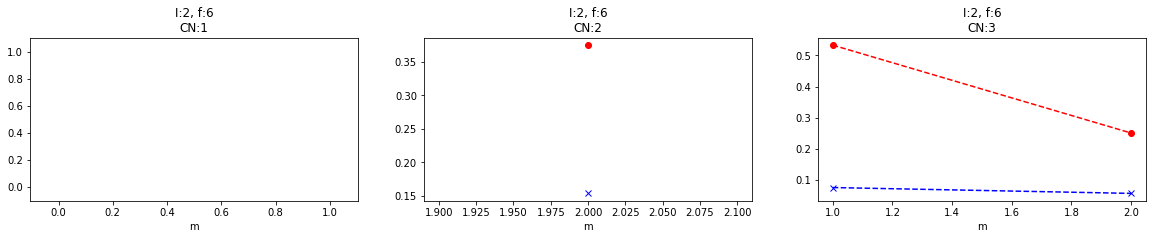

(3, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(6, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(9, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(12, 2)
1 [array([0]), array([11]), array([6]), array([11]), array([5]), array([11]), array([11]), array([9]), array([8]), array([7])]
(6, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([],

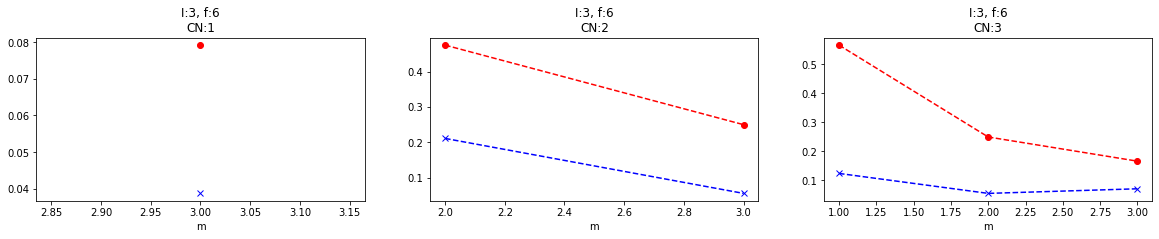

(6, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(8, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
(10, 2)
1 [array([8]), array([7]), array([8]), array([3]), array([1]), array([4]), array([5]), array([5]), array([0]), array([4])]
(12, 2)
1 [array([0]), array([11]), array([1]), array([6]), array([4]), array([10]), array([8]), array([4]), array([8]), array([10])]
(14, 2)
1 [array([7]), array([6]), array([12]), array([13]), array([3]), array([9]), array([10]), array([9]), array([0]), array([9])]
(8, 2)
0 [array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int

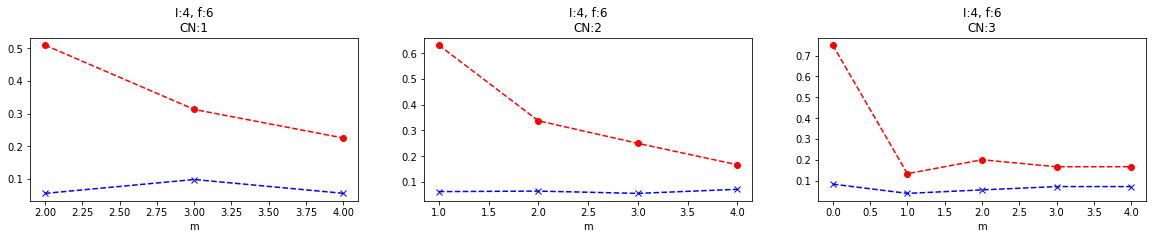

(10, 2)
1 [array([7]), array([9]), array([2]), array([8]), array([4]), array([8]), array([3]), array([6]), array([2]), array([6])]
(11, 2)
1 [array([2]), array([6]), array([0]), array([9]), array([4]), array([1]), array([8]), array([3]), array([1]), array([2])]
(12, 2)
1 [array([8]), array([8]), array([2]), array([0]), array([5]), array([11]), array([7]), array([7]), array([5]), array([1])]
(13, 2)
1 [array([1]), array([6]), array([8]), array([3]), array([10]), array([5]), array([11]), array([11]), array([5]), array([10])]
(14, 2)
1 [array([5]), array([0]), array([6]), array([10]), array([12]), array([6]), array([7]), array([5]), array([2]), array([4])]
(15, 2)
1 [array([12]), array([6]), array([5]), array([10]), array([11]), array([3]), array([0]), array([7]), array([5]), array([3])]
(11, 2)
1 [array([3]), array([10]), array([3]), array([2]), array([2]), array([10]), array([5]), array([5]), array([9]), array([6])]
(12, 2)
1 [array([11]), array([6]), array([8]), array([9]), array([3]),

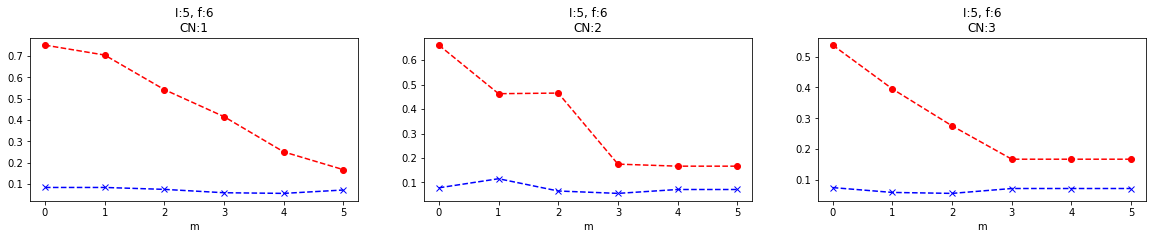

In [22]:
ploting_all_parameters(final=6, lmax=3, loops=10, CN=True, DIR=False)

/home/jorge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


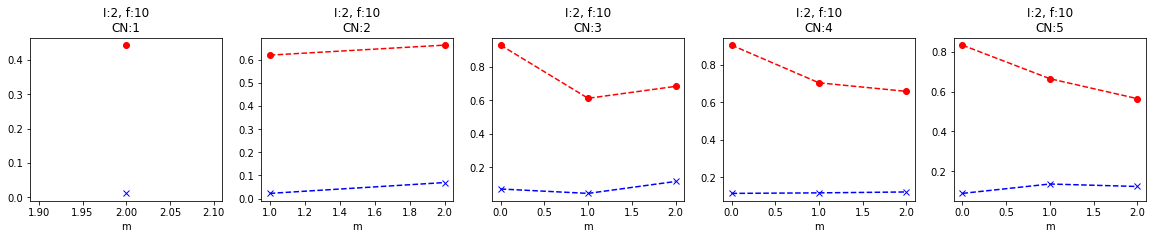

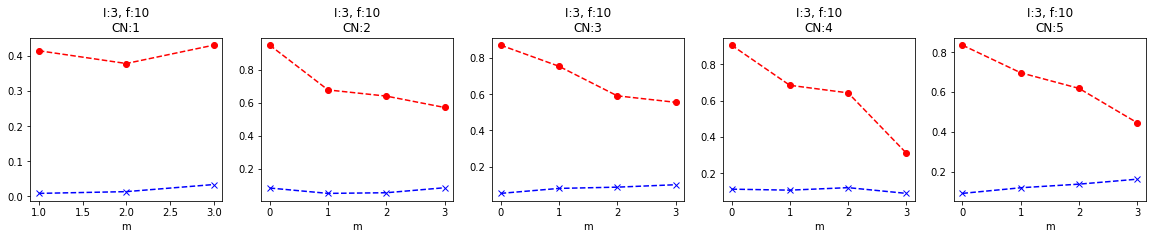

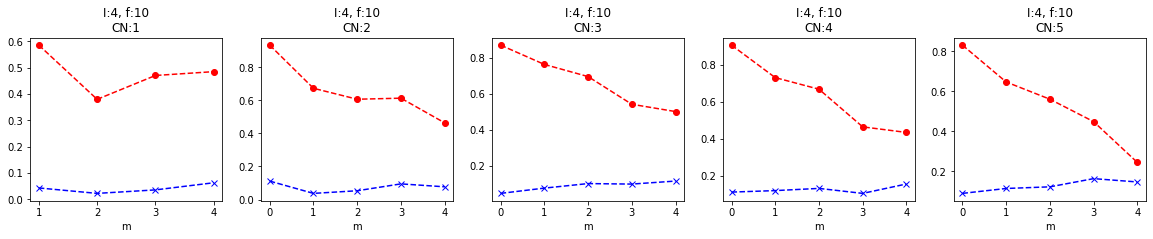

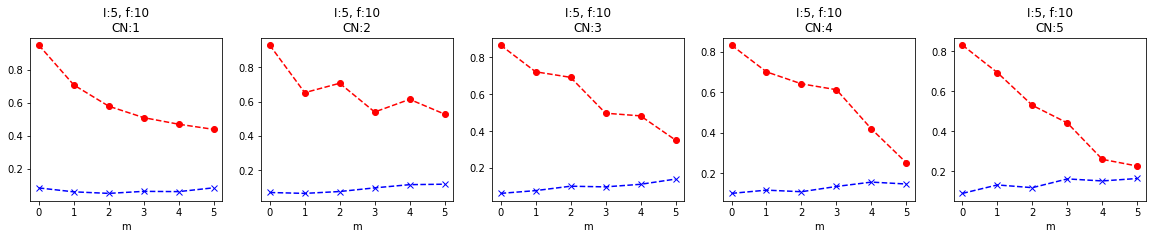

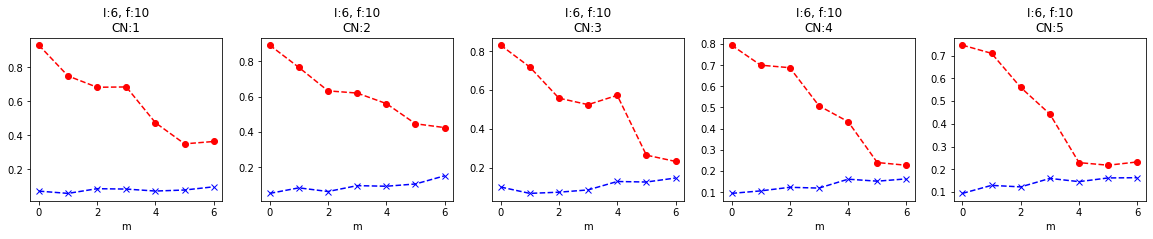

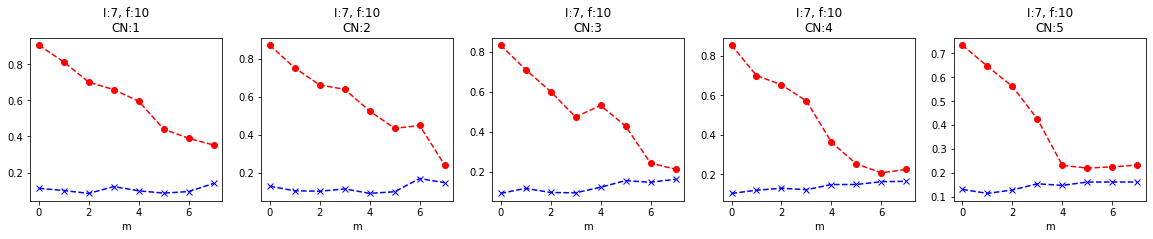

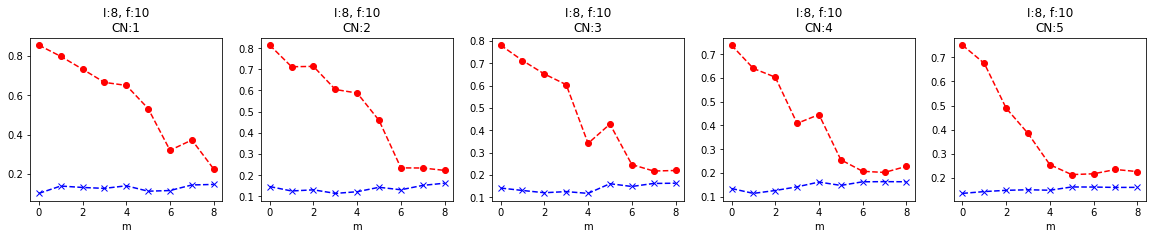

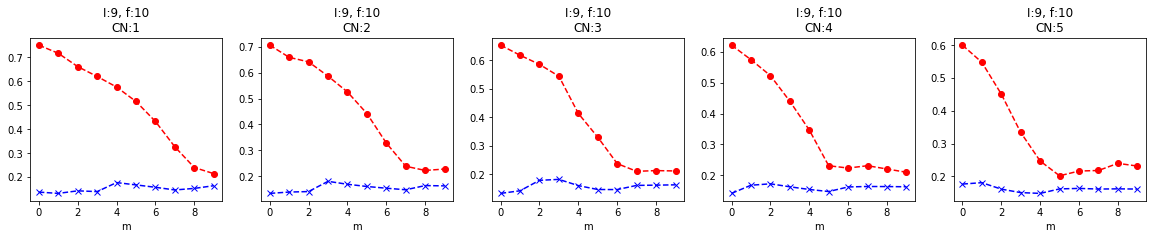

In [18]:
ploting_all_parameters(final=10, lmax=5, loops=100, CN=True, DIR=False)